## Trading on News and Tweets: A sentiment-driven arbitrage strategy on Dogecoin and TSLA based on local lagged transfer entropy

Authors: 

**Mert Ülgüner**

**Zhuofu Zhou**

This notebook demonstrates the main part of the project from the course Financial Big Data.

### 0. Preparation

Here we import the necessary backages and model before the analysis.

In [114]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from binance.client import Client
import kagglehub
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
import yfinance as yf
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm
from utils.helpers import *
from utils.pipelines import *
from models.classifier import *
from utils.calibration import *
from utils.visualization import *
from utils.constants import Constant

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
C = Constant()
Switch = True # Set it to true to run the data prepocessing again
model, tokenizer = load_sentiment_model("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
def distill_roberta_classify_sentiment(article):
    inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=32)
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    # Get maxidx
    return int(outputs.logits.argmax() - 1)

### 1. Sentiment Analysis for information



**Here we start our data processing work to convert the news or tweets to the sentiment**

Assume that the dataset of the information is a constant flow, we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Note that the news are always released in two ways: one is that the news are released at **midnight(or non-trading time) in batches**, the others are released during **trading time without batches(flow-released news)**. For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \frac{1}{|N^s_t|}\sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the asset $s$. $|N^s_t|$ is the number of the information released at time $t$ for asset $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from asset to asset.

In [22]:
tsla_news = read_file(f"{C.raw_data_dir}TSLA_news.parquet")

In [36]:
if Switch:
    tsla_news = read_file(f"{C.raw_data_dir}TSLA_news.parquet")
    #Sentiment Analysis on Tesla Stock"
    start_time = time.time()
    tqdm.pandas()
    tsla_news['Sentiment'] = tsla_news['Article_title'].progress_apply(distill_roberta_classify_sentiment)
    end_time = time.time()
    print(f'The average inference time for sentiment analysis of one news is {1000*(end_time - start_time)/tsla_news.shape[0]:.4f} ms.')
    #Preprocess and write the file
    tsla_news = tsla_news.rename({"Date":"date","Article_title":"text"}, axis = 1).filter(["date","text","Sentiment"])
    tsla_news["date"] = tsla_news["date"].apply(lambda val: pd.to_datetime(val))

    #Writing the file
    write_file(tsla_news,f"{C.clean_data_dir}tsla_news_with_sent.csv")

100%|██████████| 10587/10587 [06:33<00:00, 26.92it/s]


The average inference time for sentiment analysis of one news is 37.1478 ms.


In [37]:
if Switch:
    tweet_df = read_file(f"{C.raw_data_dir}elon_musk_tweets.csv")
    # Sentiment Analysis on musk tweet
    tweet_df = tweet_df.filter(["date", "text"])
    tqdm.pandas()
    tweet_df['Sentiment'] = tweet_df['text'].progress_apply(distill_roberta_classify_sentiment)

    # Convert 'date' column to datetime format
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])

    # Sort DataFrame by datetime
    tweet_df = tweet_df.sort_values(by='date', ascending=True).reset_index(drop=True)

    write_file(tweet_df,f"{C.clean_data_dir}musk_tweets_with_sent.csv")

100%|██████████| 5904/5904 [03:46<00:00, 26.11it/s]


Get the crypto market news data

In [38]:
if Switch:
    crypto_market_news_df = read_file(f"{C.raw_data_dir}crypto_news.csv")
    #First we get the date and the text and then we filter the subject as "altcoin" as Dogecoin is an altcoin
    filtered_news_df = crypto_market_news_df[crypto_market_news_df["subject"] == "altcoin"].filter(["date","text"])
    tqdm.pandas()
    filtered_news_df['Sentiment'] = filtered_news_df['text'].progress_apply(distill_roberta_classify_sentiment)

    #Preprocessing the crypto news data
    filtered_news_df["date"] = filtered_news_df["date"].apply(lambda val: pd.to_datetime(val))

    #Writing the file
    write_file(filtered_news_df, f"{C.clean_data_dir}crypto_news_with_sent.csv")

100%|██████████| 9278/9278 [06:52<00:00, 22.51it/s]


Merging the dataframes

In [41]:
if Switch:
    # Convert 'date' columns to datetime format
    filtered_news_df['date'] = pd.to_datetime(filtered_news_df['date'])
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])

    # Remove timezone information (if any)
    filtered_news_df['date'] = filtered_news_df['date'].dt.tz_localize(None)
    tweet_df['date'] = tweet_df['date'].dt.tz_localize(None)

    # Merge the DataFrames with an indicator
    merged_df = pd.concat(
        [filtered_news_df, tweet_df],
        keys=['Crypto_News', 'Tweet'],  # Add keys to identify the source
        names=['Source', 'Index']  # Name the multi-index levels
    ).reset_index(level=0)  # Move the 'Source' level to a column

    # Sort by date
    merged_df = merged_df.sort_values(by='date').reset_index(drop=True)

    # Add a 'Source' column to tsla_news
    tsla_news['Source'] = 'Tesla_News'

    # Convert 'date' column to datetime
    tsla_news['date'] = pd.to_datetime(tsla_news['date'])

    # Merge the DataFrames
    combined_df = pd.concat([merged_df, tsla_news], ignore_index=True)

    # Sort by date
    combined_df = combined_df.sort_values(by='date').reset_index(drop=True)

    #Writing to processed
    write_file(combined_df, f"{C.processed_data_dir}final_df.csv")

    combined_df

The average time to conduct a sentiment analysis for one information(e.g. news, twitter posts) is around 7.6ms, which is fast enough in the real-world trading.

# Trading Strategy Construction

Extract the merged market news data to start our main analysis

In [42]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
data

,Source,date,text,Sentiment
0,Tesla_News,2019-07-01 00:00:00,Tesla shares are trading higher after JMP Secu...,1
1,Tesla_News,2019-07-01 00:00:00,Tesla's Q2 Delivery Number Could Cause A Big Move,1
2,Tesla_News,2019-07-01 00:00:00,"UPDATE: JMP Reiterates Outperform, $347 Target...",1
3,Tesla_News,2019-07-01 00:00:00,'Tesla Electric Airplane? Elon Musk sees elect...,0
4,Tesla_News,2019-07-02 00:00:00,"Tesla, Unum Therapeutics Making Big Moves In T...",0
...,...,...,...,...
25764,Crypto_News,2023-12-18 20:56:00,BEEG's adoption skyrockets as 37% is minted wi...,1
25765,Crypto_News,2023-12-18 21:47:07,Here is our weekly collection of digital asset...,0
25766,Crypto_News,2023-12-18 22:48:00,Tether asserts to have effectively immobilized...,0
25767,Crypto_News,2023-12-18 23:48:19,"The new CEO, Josh Swihart, has been the vice p...",0


# **First Analysis**: TESLA NEWS ON TESLA PRICE

In [46]:
#Tesla price data
tsla_price = read_file("./data/clean/tesla_quotes.csv")
tsla_price = tsla_price[["Date","Close"]].rename({"Date":"date"}, axis = 1) 

### 2. Return-data preprocessing

#### Now that we have our data set with the sentiments, we want to link it to our stock price

Discretize the tick-by-tick data to align with the news-data, by identifying the return of the price. When the batch news are released in non-trading time, assume that the traders in the market will react to the news as soon as the trading time starts, for flow-released news, assume that the market participants will react as soon as the information of the news is understood. There will be **one hyperparameter**:
  - The time-lag between the new release and the market reaction: $\gamma$

Set the return of the stock as positive, stable and negative under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock return.

The formula for the stochastic process of the discretized return can be written as 

$$
\hat{R}_{t}^{s} = h(\log \frac{P_{t + 1}^{s}}{P_{t}^{s}}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma > 0
$$

 - $P_{t}^{s}$ is the price of stock $s$ at proxy time $t$
 - $(\log \frac{P_{t + 1}^{s}}{P_{t}^{s}})$ is the daily log-return


 - News published after 4 PM is assigned to the next trading day

 - Sentiment data is aggregated by trading day using the mean

 - Left join with returns_data to retain the time from the sentiment data, which refers to the **proxy time**, the time that one **information** is released.

In [47]:
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Tesla_News"]

intermediate_data = process_and_merge_data(tsla_price,sentiment_data)

intermediate_data['date'] = pd.to_datetime(intermediate_data['date'])

#Cutoff value for Tesla
intermediate_data = intermediate_data[intermediate_data['date'] >= pd.Timestamp('2022-05-02')].reset_index(drop = True)

intermediate_data.head()

,Trading_date,Sentiment,date,Close
0,2022-05-02,0.176471,2022-05-02,300.980011
1,2022-05-03,0.320000,2022-05-03,303.083344
2,2022-05-04,-0.285714,2022-05-04,317.540009
3,2022-05-05,-0.333333,2022-05-05,291.093323
4,2022-05-06,-0.105263,2022-05-06,288.549988


In [48]:
#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(intermediate_data)
intermediate_data.head()

,Trading_date,Sentiment,date,Close,Log_Return
1,2022-05-03,0.320000,2022-05-03,303.083344,0.006964
2,2022-05-04,-0.285714,2022-05-04,317.540009,0.046596
3,2022-05-05,-0.333333,2022-05-05,291.093323,-0.086960
4,2022-05-06,-0.105263,2022-05-06,288.549988,-0.008776
5,2022-05-09,-0.272727,2022-05-09,262.369995,-0.095113


In [49]:
write_file(intermediate_data,f"{C.processed_data_dir}input_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

### 3.Get transfer entropy

After we construct on the two stochastic processes $I_{t}^{s}$ and $R_{t}^{s}$, calculate the transfer entropy of the two random processes

Before we move on, we **discretize** the sentiment scores to get into the value range (-1,0,1) as we took the average when converting them into daily scores. Therefore, we are going to have an additional parameter when classifying:

$$
\hat{I}_t^s =
\begin{cases} 
1, & \hat{I}_t^s > \beta \quad (\text{Positive sentiment}) \\\
0, & -\beta \leq I_t^s \leq \beta \quad (\text{Neutral sentiment}) \\\
-1, & I_t^s < -\beta \quad (\text{Negative sentiment})
\end{cases}
$$

The transfer entropy is revised to be a **lagged-$\Delta$ conditional/local transfer entropy**, which $\Delta$ is the lagged time for the market participants to react on the news release, and $\lambda$ is the fixed time window on the local/conditional entropy.

$$
TE(\hat{I}_{t}^{s}, \hat{R}_{t+\Delta}^{s} |\lambda)
$$

Mapping the states (-1,0,1) so that there are no negative-valued states don't change the result of the transfer entropy **(detail this part)**

### 4. Design trading strategy

Based on the sentiment process $\hat{I}_{t}^{s}$ and the transfer entropy $TE(\hat{I}_{t}^{s}, \hat{R}_{t+\Delta}^{s} |\lambda)$ , design a statistic arbitrage trading strategy **(only one idea)** as follows:

````python
if (sentiment_score > 0) & (TE>threshold):
    buy stock at time t + delta - 1
    sell stock at time t + delta
elif (sentiment_score < 0) & (TE>threshold):
    short sell stock at time t + delta - 1
    buy back stock at time t + delta
else:
    continue
````

The ``threshold`` can be written as $\alpha$ for further demonstration.

### 5. Calibration and train-validation-test split

Based on the arbitrage strategy, we have several hyperparameters to be calibrated: $\delta, \gamma, \Delta, \lambda, \alpha$. The hyperparameters should be calibrated using the in-sample training set and validation set, and perform stimulation trading on the out-of-sample test set. The size of the whole train-validation-test set should be fixed and moved along the time with the moving interval to be the exact size of the test set, only using the most recent data and construct a trading performance over the whole dataframe.

Within one single train-validation-test set, the best hyperparameters for each asset $s$ are found based on the Sharpe ratio of the strategy in the **validation set**. The way of finding the best hyperparameters should be done by grid search.

In [51]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.005,
    'beta': 0.3,
    'delta': 1,
    'lambda': 10,
    'alpha': 0.2
}



summary_df_1 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.005, 0.01, 0.015],
    beta_values = [0.3, 0.5, 0.7],
    delta_values = [1, 2, 5],
    lambda_values = [5, 10, 15],
    alpha_values = [0.1, 0.2, 0.5],
    window_size=100,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar): 100%|██████████| 310/310 [02:10<00:00,  2.37it/s]


In [53]:
summary_df_1.head()

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.005, 'beta': 0.3, 'delta': 5, 'lam...",0.223607,-0.213483,-0.001246,-0.024950,1.000000
1,1,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,0.188954,0.001516,0.030137,1.000000
2,2,"{'gamma': 0.01, 'beta': 0.3, 'delta': 2, 'lamb...",0.292407,-0.289775,-0.000254,-0.005073,1.000000
3,3,"{'gamma': 0.01, 'beta': 0.3, 'delta': 1, 'lamb...",0.292467,-0.318906,-0.002093,-0.041440,1.017362
4,4,"{'gamma': 0.01, 'beta': 0.3, 'delta': 1, 'lamb...",0.340906,-0.318906,-0.002093,-0.041440,1.000000


In [54]:
write_file(summary_df_1, f"{C.processed_data_dir}summary_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")

# **DOGE COIN ANALYSIS**

## Second Analysis: **CRYPTO NEWS ON DOGECOIN PRICE**

Get the return data for DOGECOIN

In [80]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
#Doge price data
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]

In [84]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
#Doge price data
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
sentiment_data = data[data["Source"] == "Crypto_News"]

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,date,Sentiment,Open,Log_Return
1,2021-11-04 16:32:00+00:00,0.0,0.2571,-0.017352
2,2021-11-05 13:37:00+00:00,0.0,0.2630,0.022689
3,2021-11-05 15:39:00+00:00,-1.0,0.2598,-0.012242
4,2021-11-08 14:44:00+00:00,1.0,0.2761,0.060851
5,2021-11-08 20:00:00+00:00,0.0,0.2815,0.019369


In [85]:
write_file(intermediate_data,f"{C.processed_data_dir}input_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

In [86]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_2 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar): 100%|██████████| 8191/8191 [1:07:28<00:00,  2.02it/s]


In [87]:
summary_df_2

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.080945,0.023112,0.000060,0.011356,1.000000
1,1,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.023112,0.000060,0.011356,1.000000
2,2,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.000000
3,3,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.000000
4,4,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.007741,0.000019,0.003247,1.000000
...,...,...,...,...,...,...,...
8186,8186,"{'gamma': 0.001, 'beta': 0.3, 'delta': 10, 'la...",0.117846,-0.037364,-0.000207,-0.043570,0.996808
8187,8187,"{'gamma': 0.001, 'beta': 0.3, 'delta': 10, 'la...",0.117846,-0.043473,-0.000244,-0.050673,1.014433
8188,8188,"{'gamma': 0.001, 'beta': 0.3, 'delta': 10, 'la...",0.117846,-0.047735,-0.000268,-0.055254,1.003715
8189,8189,"{'gamma': 0.001, 'beta': 0.3, 'delta': 10, 'la...",0.109797,-0.079780,-0.000416,-0.082290,1.000000


In [88]:
write_file(summary_df_2, f"{C.processed_data_dir}ESS_summary_df_analysis_2(Crypto_News_on_Doge_Price).parquet")

## Third Analysis: **Elon's Tweets added to Crypto NEWS on DOGE**

In [89]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
#Doge price data
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data[(data["Source"] == "Crypto_News") | (data["Source"] == "Tweet") ]

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute
c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,date,Sentiment,Open,Log_Return
1,2021-11-04 16:32:00+00:00,0.0,0.2571,-0.017352
2,2021-11-05 13:37:00+00:00,0.0,0.2630,0.022689
3,2021-11-05 15:39:00+00:00,-1.0,0.2598,-0.012242
4,2021-11-08 14:44:00+00:00,1.0,0.2761,0.060851
5,2021-11-08 20:00:00+00:00,0.0,0.2815,0.019369


In [90]:
write_file(intermediate_data,f"{C.processed_data_dir}input_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

In [91]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_3 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar): 100%|██████████| 13962/13962 [1:44:30<00:00,  2.23it/s]


In [92]:
summary_df_3.head()

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.080945,0.023112,0.000060,0.011356,1.0
1,1,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.023112,0.000060,0.011356,1.0
2,2,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.0
3,3,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.0
4,4,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.007741,0.000019,0.003247,1.0


In [93]:
write_file(summary_df_3, f"{C.processed_data_dir}ESS_summary_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")

## Fourth Analysis: **Elon's Tweets, Crypto NEWS and TESLA NEWS on DOGE**

In [94]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
#Doge price data
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,date,Sentiment,Open,Log_Return
294,2021-11-04 16:32:00+00:00,0.0,0.2571,-0.017352
295,2021-11-05 13:37:00+00:00,0.0,0.2630,0.022689
296,2021-11-05 15:39:00+00:00,-1.0,0.2598,-0.012242
297,2021-11-08 14:44:00+00:00,1.0,0.2761,0.060851
298,2021-11-08 20:00:00+00:00,0.0,0.2815,0.019369


In [95]:
write_file(intermediate_data,f"{C.processed_data_dir}input_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

In [96]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.00015,
    'beta': 0.3,
    'delta': 1,
    'lambda': 30,
    'alpha': 0.1
}

summary_df_4 = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    gamma_values = [0.0003,0.001],
    beta_values = [0.3,0.7],
    delta_values = [5,10],
    lambda_values = [30,60],
    alpha_values = [0.1,0.5],
    window_size=1000,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func_with_parallelization
)

Rolling Calibration (One Bar): 100%|██████████| 14539/14539 [1:50:41<00:00,  2.19it/s]


In [97]:
summary_df_4.head()

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return,last_time_step_return
0,0,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.080945,0.023112,0.000060,0.011356,1.0
1,1,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.023112,0.000060,0.011356,1.0
2,2,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.0
3,3,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.025968,0.000067,0.012841,1.0
4,4,"{'gamma': 0.0003, 'beta': 0.3, 'delta': 5, 'la...",0.124696,0.007741,0.000019,0.003247,1.0


In [98]:
write_file(summary_df_4, f"{C.processed_data_dir}ESS_summary_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")

In [105]:
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet")

In [106]:
doge_price

,Date,Open
0,2021-11-04 00:00:00+00:00,0.26890
1,2021-11-04 00:01:00+00:00,0.26910
2,2021-11-04 00:02:00+00:00,0.26970
3,2021-11-04 00:03:00+00:00,0.26980
4,2021-11-04 00:04:00+00:00,0.26950
...,...,...
1133197,2023-12-30 23:56:00+00:00,0.09004
1133198,2023-12-30 23:57:00+00:00,0.09005
1133199,2023-12-30 23:58:00+00:00,0.09004
1133200,2023-12-30 23:59:00+00:00,0.08998


### Result Visualization

In [120]:
#Read the summary dataframes of the strategies
strategy_1_input = read_file(f"{C.processed_data_dir}input_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")
strategy_1_output = read_file(f"{C.processed_data_dir}summary_df_analysis_1(Tesla_News_on_Tesla_Price).parquet")
tsla_price = read_file(f"{C.clean_data_dir}tesla_quotes.csv")

c:\Users\floyd\Desktop\financial-big-data-project\utils\visualization.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark["Log_return"] = np.log(benchmark['Close']/benchmark['Close'].shift(1)).fillna(0)
c:\Users\floyd\Desktop\financial-big-data-project\utils\visualization.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark['benmark_cumulative_return'] = (benchmark['Log_return']+1).cumprod()


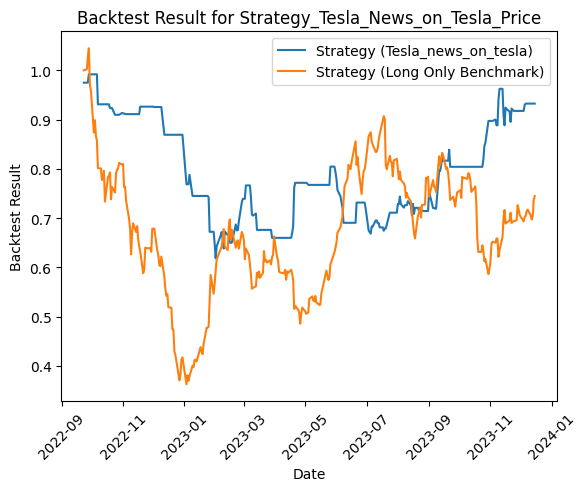

In [123]:
plot_transformed_cumulative_return(strategy_1_input,strategy_1_output,"Tesla_News_on_Tesla_Price",tsla_price,99,transform_cumulative_returns)

From the plot, we can see that the trading strategy for TSLA is not profitable. The reason behind this could be that the quality of the data is not good, while the news mostly are labelled to be released at midnight, causing the signal from the news not being captured by our strategy in time. Moreover, the price data we're currently working with especially with TSLA is daily-frequency data, which results in the delay for our strategy implemetation to catch the immediate impact from the information.

In [115]:
strategy_2_input = read_file(f"{C.processed_data_dir}input_df_analysis_2(Crypto_News_on_Doge_Price).parquet")
strategy_2_output = read_file(f"{C.processed_data_dir}ESS_summary_df_analysis_2(Crypto_News_on_Doge_Price).parquet")
strategy_3_input = read_file(f"{C.processed_data_dir}input_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")
strategy_3_output = read_file(f"{C.processed_data_dir}ESS_summary_df_analysis_3(Crypto_News+Tweets_on_Doge_Price).parquet")
strategy_4_input = read_file(f"{C.processed_data_dir}input_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")
strategy_4_output = read_file(f"{C.processed_data_dir}ESS_summary_df_analysis_4(Crypto_News+Tweets+Tesla_News_on_Doge_Price).parquet")
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet")

c:\Users\floyd\Desktop\financial-big-data-project\utils\visualization.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df["Log_return"] = np.log(benchmark_df['Open']/benchmark_df['Open'].shift(1)).fillna(0)
c:\Users\floyd\Desktop\financial-big-data-project\utils\visualization.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['benmark_cumulative_return'] = (benchmark_df['Log_return']+1).cumprod()


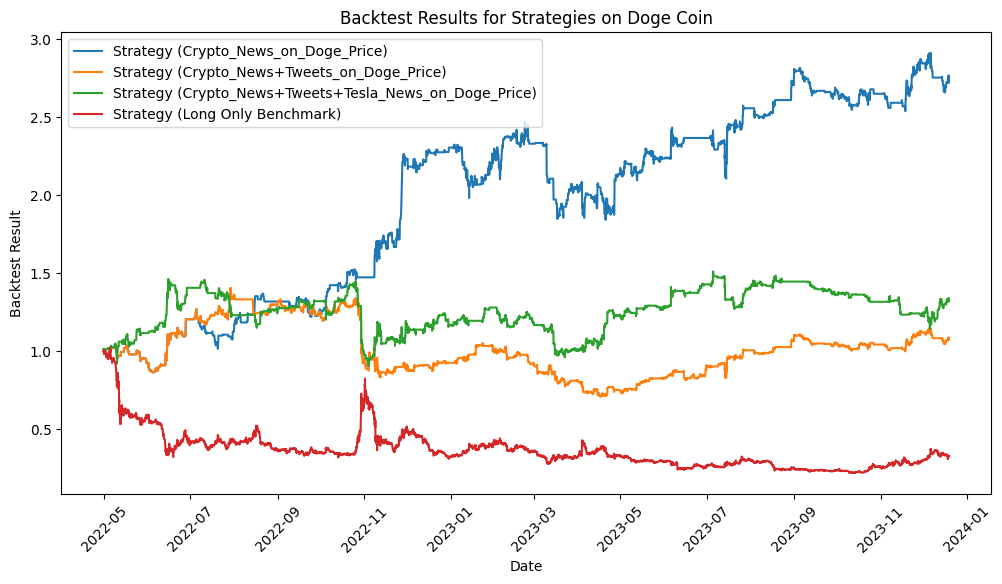

In [124]:
plot_transformed_backtest_results([strategy_2_input,strategy_3_input,strategy_4_input],
                                  [strategy_2_output,strategy_3_output,strategy_4_output],
                                  ["(Crypto_News_on_Doge_Price)","(Crypto_News+Tweets_on_Doge_Price)","(Crypto_News+Tweets+Tesla_News_on_Doge_Price)"],
                                  doge_price,
                                  999,
                                  transform_cumulative_returns,
                                  'Backtest Results for Strategies on Doge Coin')

From the result, we can see that with only utiliting the altcoin news to capture the information signal, the strategy provides good results in regards with dogecoin. By combing elon musk's tweets, the strategy pro